In [2]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import pygrib
import netCDF4
import scipy
import pickle
import matplotlib.pyplot as plt
DATA_DIR="/root/data_downloads"
era5_multi_level_dir=f"{DATA_DIR}/era5/multi"
era5_single_level_dir=f"{DATA_DIR}/era5/single"
%alias mkdatadir mkdir -p %l

## Get get ibtracs labels for current year

In [3]:
s3key = "data/ibtracs/IBTrACS.since1980.v04r00.nc"
ibtracs_dir = f"{DATA_DIR}/ibtracs"

%mkdatadir $ibtracs_dir
# dest = "/data_downloads/ibtracs/IBTrACS.ALL.v04r00.nc"
ibtracs_dest = f"{ibtracs_dir}/IBTrACS.since1980.v04r00.nc"
if os.path.exists(ibtracs_dest):
    print(f"{ibtracs_dest} already downloaded")
else:
    s3 = boto3.client('s3')
    s3.download_file(bucket, s3key, ibtracs_dest)
    print(f"downloaded {ibtracs_dest}")

/root/data_downloads/ibtracs/IBTrACS.since1980.v04r00.nc already downloaded


In [4]:
ibtracs_nc = netCDF4.Dataset(ibtracs_dest)
"""
Need to combine the datasets by hour.  Will want to OR the storms together where they share hours 
to produce a global mask of TC labels.  This will then be included in the outputted netcdf files.
"""
def ibtracs_time_to_pd_timestamp(ibtracs_time):
    ts = pd.to_datetime(ibtracs_time)
    return ts


ibtracs_roci = ibtracs_nc.variables["bom_roci"]
start_year = 2018
end_year = 2018
timestamp_storms = {}
print_freq = 100

if os.path.exists("timestamp_storms.pickle"):
    with open("timestamp_storms.pickle", "rb") as file:
        print("timestamp_storms.pickle exists, skipping...") 
        timestamp_storms = pickle.load(file)
else:
    for storm_idx, storm_times in enumerate(ibtracs_nc.variables["iso_time"][:]):
        for time_idx, time in enumerate(storm_times):
            timestamp_str = time.tobytes().decode("utf-8")
            if not timestamp_str:
                break # we have hit the last timestamp for the storm
            # Convert byte arrays to pandas Timestamp
            timestamp = ibtracs_time_to_pd_timestamp(timestamp_str) # 
            if start_year <= timestamp.year <= end_year:
                storm_tup = (storm_idx, time_idx)
                if timestamp_str in timestamp_storms:
                    timestamp_storms[timestamp_str].append(storm_tup)
                else:
                    timestamp_storms[timestamp_str] = [storm_tup]
        if storm_idx % print_freq == 0:
            print(f"{storm_idx} of {ibtracs_nc.variables['iso_time'].shape[0]}")


timestamp_storms.pickle exists, skipping...


In [5]:
print(f"Storms found at {len(timestamp_storms)} timestamps in the {start_year}-{end_year} year range")

Storms found at 2759 timestamps in the 2018-2018 year range


## Process ERA5 data and output augmented netcdf file for each day
Note: time in this dataset has units: hours since 1900-01-01 00:00:00.0
can be converted to a pandas timestamp with
```
pd.to_datetime(timestamp, unit='h', origin='1900-01-01 00:00:00.0')
```
and can do the reverse conversion via
```
origin = pd.Timestamp('1900-01-01 00:00:00')
hours_since_1900 = int((pandas_timestamp - origin).total_seconds() / 3600)
```


In [6]:
year = "2018"
month = "01"
day = "01"
# filename=f'{era5_single_level_dir}/{year}-{month}-{day}.grib'
single_file=f'{era5_single_level_dir}/{year}-{month}-{day}.nc'
multi_file=f'{era5_multi_level_dir}/{year}-{month}-{day}.nc'

single_nc =  netCDF4.Dataset(single_file)
multi_nc =  netCDF4.Dataset(multi_file)
single_vars = single_nc.variables.keys()
multi_vars = multi_nc.variables.keys()


# mtpr = xr.DataArray(single_nc.variables["mtpr"], coords={
#     'time': single_nc.variables["time"][:],
#     'lat': single_nc.variables["latitude"][:], 
#     'lon': single_nc.variables["longitude"][:]}, 
#     dims=('time','lat', 'lon'))

# sp = xr.DataArray(single_nc.variables["sp"], coords={
#     'time': single_nc.variables["time"][:],
#     'lat': single_nc.variables["latitude"][:], 
#     'lon': single_nc.variables["longitude"][:]}, 
#     dims=('time','lat', 'lon'))

# tcwv = xr.DataArray(single_nc.variables["tcwv"], coords={
#     'time': single_nc.variables["time"][:],
#     'lat': single_nc.variables["latitude"][:], 
#     'lon': single_nc.variables["longitude"][:]}, 
#     dims=('time','lat', 'lon'))

# pv850 = xr.DataArray(multi_nc.variables["pv"], coords={
#     'time': multi_nc.variables["time"][:],
#     'lat': multi_nc.variables["latitude"][:], 
#     'lon': multi_nc.variables["longitude"][:]}, 
#     dims=('time','lat', 'lon'))

# u850 = xr.DataArray(multi_nc.variables["u"], coords={
#     'time': multi_nc.variables["time"][:],
#     'lat': multi_nc.variables["latitude"][:], 
#     'lon': multi_nc.variables["longitude"][:]}, 
#     dims=('time','lat', 'lon'))

# v850 = xr.DataArray(multi_nc.variables["v"], coords={
#     'time': multi_nc.variables["time"][:],
#     'lat': multi_nc.variables["latitude"][:], 
#     'lon': multi_nc.variables["longitude"][:]}, 
#     dims=('time','lat', 'lon'))

# ws850 = (u850**2 + v850**2)**0.5
# print(v850, ws850)


## Compute labels

In [9]:
def haversine_distance(lat, lon, lat_center, lon_center):
    """
    returns matrix of dim (lat,lon) with distance in nautical miles
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat, lon, lat_center, lon_center])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat[:,None] / 2) ** 2 + np.cos(lat1[:,None]) * np.cos(lat2) * np.sin(dlon[None,:] / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of the Earth in kilometers

    # Calculate the distance in 
    distance = c * r
    # 1.852 km per nautical mile
    return distance / 1.852


def make_labeled_dataset(pd_timestamp, timestep_labels, regrid_target=None)->xr.Dataset:
    """
    Take a timestamp and the labels for the timestamp, combine with
    ERA5 data, regrid, and return an xarray Dataset.  These datasets
    can later be concatenated along the time dimension before being 
    written to a file.
    
    We try to match the format of the climatenet augmented dataset.
    The ClimateDatasetLabeled class concatenates files across the 
    time dimension, so we can put as many timesteps as we want in 
    each file. Here we take the timestep and find the matching 
    ERA5 file and extract the variables for the corresponding timestamp.
    
    
    Only some variables are provided here.  If more are desired, they
    can be additionally downloaded from copernicus. 
    
    Augmented climatenet dataset:
    dimensions(sizes): lat(768), lon(1152), time(1)
    variables(dimensions): float64 lat(lat), float64 lon(lon), 
        float32 TMQ(time, lat, lon), float32 U850(time, lat, lon), 
        float32 V850(time, lat, lon), float32 UBOT(time, lat, lon), 
        float32 VBOT(time, lat, lon), float32 QREFHT(time, lat, lon), 
        float32 PS(time, lat, lon), float32 PSL(time, lat, lon), 
        float32 T200(time, lat, lon), float32 T500(time, lat, lon), 
        float32 PRECT(time, lat, lon), float32 TS(time, lat, lon), 
        float32 TREFHT(time, lat, lon), float32 Z1000(time, lat, lon), 
        float32 Z200(time, lat, lon), float32 ZBOT(time, lat, lon), 
        <class 'str'> time(time), int64 LABELS(lat, lon)
    """
    origin = pd.Timestamp('1900-01-01 00:00:00')
    hours_since_1900 = int((pd_timestamp - origin).total_seconds() / 3600)
    year = pd_timestamp.year
    month = pd_timestamp.strftime('%m')
    day = pd_timestamp.strftime('%d')
    # filename=f'{era5_single_level_dir}/{year}-{month}-{day}.grib'
    single_file=f'{era5_single_level_dir}/{year}-{month}-{day}.nc'
    multi_file=f'{era5_multi_level_dir}/{year}-{month}-{day}.nc'

    single_nc =  netCDF4.Dataset(single_file)
    multi_nc =  netCDF4.Dataset(multi_file)
    single_vars = single_nc.variables.keys()
    multi_vars = multi_nc.variables.keys()


    mtpr = xr.DataArray(single_nc.variables["mtpr"], name="PRECT", coords={
        'time': single_nc.variables["time"][:],
        'lat': single_nc.variables["latitude"][:], 
        'lon': single_nc.variables["longitude"][:]}, 
        dims=('time','lat', 'lon')).sel(time=hours_since_1900)

    sp = xr.DataArray(single_nc.variables["sp"], name="PSL", coords={
        'time': single_nc.variables["time"][:],
        'lat': single_nc.variables["latitude"][:], 
        'lon': single_nc.variables["longitude"][:]}, 
        dims=('time','lat', 'lon')).sel(time=hours_since_1900)

    tcwv = xr.DataArray(single_nc.variables["tcwv"], name="TMQ", coords={
        'time': single_nc.variables["time"][:],
        'lat': single_nc.variables["latitude"][:], 
        'lon': single_nc.variables["longitude"][:]}, 
        dims=('time','lat', 'lon')).sel(time=hours_since_1900)

    pv850 = xr.DataArray(multi_nc.variables["pv"], name="VRT850", coords={
        'time': multi_nc.variables["time"][:],
        'lat': multi_nc.variables["latitude"][:], 
        'lon': multi_nc.variables["longitude"][:]}, 
        dims=('time','lat', 'lon')).sel(time=hours_since_1900)

    u850 = xr.DataArray(multi_nc.variables["u"], name="U850", coords={
        'time': multi_nc.variables["time"][:],
        'lat': multi_nc.variables["latitude"][:], 
        'lon': multi_nc.variables["longitude"][:]}, 
        dims=('time','lat', 'lon')).sel(time=hours_since_1900)

    v850 = xr.DataArray(multi_nc.variables["v"], name="V850", coords={
        'time': multi_nc.variables["time"][:],
        'lat': multi_nc.variables["latitude"][:], 
        'lon': multi_nc.variables["longitude"][:]}, 
        dims=('time','lat', 'lon')).sel(time=hours_since_1900)

    ws850 = ((u850**2 + v850**2)**0.5).rename("WS850")
    
    labels = xr.DataArray(timestep_labels[None,:,:], name="LABELS", coords={
        'time': np.array([hours_since_1900]),
        'lat': multi_nc.variables["latitude"][:], 
        'lon': multi_nc.variables["longitude"][:]},
        dims=('time','lat', 'lon'))
    

    dataset = xr.Dataset(
        data_vars={
            "PRECT": mtpr,
            "PSL": sp,
            "TMQ": tcwv,
            "VRT850": pv850,
            "U850": u850,
            "V850": v850,
            "WS850": ws850,
            "LABELS": labels
        },
        # coords={
        #     'time': 
        # }
    )
    
    if regrid_target is not None:
        dataset = dataset.interp(lat=regrid_target.variables["lat"], lon=regrid_target.variables["lon"])
        
    
    single_nc.close()
    multi_nc.close()
    return dataset

# max_roci = np.argmax(ibtracs_nc.variables["bom_roci"])
# max_roci = np.unravel_index(max_roci, ibtracs_nc.variables["bom_roci"].shape)
# print("roci max", np.max(ibtracs.variables["bom_roci"]), max_roci)


# need to treat fill values as none or numpy gets unhappy
masked_lat = ibtracs_nc.variables["lat"][:]
masked_lat = np.ma.masked_array(masked_lat, mask=(masked_lat == ibtracs_nc.variables["lat"]._FillValue), fill_value=None)
masked_lon = ibtracs_nc.variables["lon"][:]
masked_lon = np.ma.masked_array(masked_lon, mask=(masked_lon == ibtracs_nc.variables["lon"]._FillValue), fill_value=None)
masked_roci = ibtracs_nc.variables["usa_roci"][:]
masked_roci = np.ma.masked_array(masked_roci, mask=(masked_roci == ibtracs_nc.variables["usa_roci"]._FillValue), fill_value=None)




TIMESTEPS_PER_FILE=8
unwritten_timestamps = 0
files_written = 0
start_timestamp = None
file_dataset = None
total_labeled = 0
print_freq = 100
iteration = 0
LABEL_DIR = f"{DATA_DIR}/era5_labeled_regridded"
regrid_target = netCDF4.Dataset("/data_downloads/climatenet/train/data-2005-06-24-01-1_1.nc")
completed_timestamps = set()
# if os.path.exists("completed_timestamps.pickle"):
#     with open("completed_timestamps.pickle", "rb") as file:
#         completed_timestamps = pickle.load(file)
#         print(f"Remembered completed timestamps: {completed_timestamps}")
queued_timestamps = set()
%mkdatadir $LABEL_DIR
for timestamp, storms in timestamp_storms.items():
    queued_timestamps.add(timestamp)
    # if timestamp in completed_timestamps:
    #     print(f"Already completed {timestamp}, skipping...")
    pd_timestamp = pd.to_datetime(timestamp)
    # if pd_timestamp <= pd.Timestamp("2018-08-31"):
    #     continue
    if start_timestamp is None:
        start_timestamp = pd_timestamp
    timestep_labels = np.zeros((single_nc.dimensions["latitude"].size, single_nc.dimensions["longitude"].size), dtype=np.int8)
    for storm_id,timestep in storms:
        
        distances = haversine_distance(
            single_nc.variables["latitude"], # pull out the time  
            single_nc.variables["longitude"], 
            masked_lat[storm_id,timestep], 
            masked_lon[storm_id,timestep]
        )
        storm_labels = np.where(distances <= masked_roci[storm_id,timestep], 1, 0)
        timestep_labels = timestep_labels | storm_labels
    if iteration % print_freq == 0:
        print(f"{iteration} of {len(timestamp_storms)}")
    iteration += 1
    
    # We only want to create/write the dataset if labels exist
    if np.max(timestep_labels) != 0:
        try:
            dataset = make_labeled_dataset(pd_timestamp, timestep_labels, regrid_target)
        except Exception as e:
            print(e)
            print(f"failed on timestamp {pd_timestamp}")
            continue
        unwritten_timestamps += 1
        total_labeled += 1
        if file_dataset is None:
            file_dataset = dataset
        else:
            file_dataset = xr.concat([file_dataset, dataset], dim='time')
            dataset.close()
            dataset = None
        if unwritten_timestamps == TIMESTEPS_PER_FILE:
            year = start_timestamp.year
            month = start_timestamp.strftime('%m')
            day = start_timestamp.strftime('%d')
            dest = f"{LABEL_DIR}/{year}-{month}-{day}.nc"
            print(f"Writing dataset to {dest}")
            file_dataset.to_netcdf(dest, format="NETCDF4")
            file_dataset.close()
            file_dataset = None
            start_timestamp = None
            unwritten_timestamps = 0
            completed_timestamps.update(queued_timestamps)
            queued_timestamps = set()
            with open("completed_timestamps.pickle", "wb") as file:
                pickle.dump(completed_timestamps, file)
        
if unwritten_timestamps != 0:
    year = start_timestamp.year
    month = start_timestamp.strftime('%m')
    day = start_timestamp.strftime('%d')
    dest = f"{LABEL_DIR}/{year}-{month}-{day}.nc"
    print(f"Writing final dataset to {dest}")
    file_dataset.to_netcdf(dest, format="NETCDF4")
    file_dataset.close()
    file_dataset = None
    start_timestamp = None
    unwritten_timestamps = 0
    # print(np.max(timestep_labels))
print(f"Labeled a total of {total_labeled} timesteps")
# # storm_id = 2403
# timestep = 5

# distances = haversine_distance(era5_single.variables["latitude"], era5_single.variables["longitude"], masked_lat[storm_id,timestep], masked_lon[storm_id,timestep])

# # print(distances.shape) 
# tc_label = np.where(distances <= masked_roci[storm_id,timestep], 1, 0)

0 of 2759
Writing dataset to /root/data_downloads/era5_labeled_regridded/2018-01-01.nc
Writing dataset to /root/data_downloads/era5_labeled_regridded/2018-01-02.nc
Writing dataset to /root/data_downloads/era5_labeled_regridded/2018-01-03.nc
Writing dataset to /root/data_downloads/era5_labeled_regridded/2018-01-04.nc
Writing dataset to /root/data_downloads/era5_labeled_regridded/2018-01-05.nc
Writing dataset to /root/data_downloads/era5_labeled_regridded/2018-01-06.nc
Writing dataset to /root/data_downloads/era5_labeled_regridded/2018-01-07.nc
Writing dataset to /root/data_downloads/era5_labeled_regridded/2018-01-08.nc
Writing dataset to /root/data_downloads/era5_labeled_regridded/2018-01-09.nc
Writing dataset to /root/data_downloads/era5_labeled_regridded/2018-01-10.nc
Writing dataset to /root/data_downloads/era5_labeled_regridded/2018-01-11.nc
Writing dataset to /root/data_downloads/era5_labeled_regridded/2018-01-12.nc
100 of 2759
Writing dataset to /root/data_downloads/era5_labeled_r

In [40]:
%whos

Variable                       Type              Data/Info
----------------------------------------------------------
DATA_DIR                       str               /root/data_downloads
LABEL_DIR                      str               /root/data_downloads/era5_labeled_regridded
TIMESTEPS_PER_FILE             int               8
completed_timestamps           set               {'2018-01-05 12:00:00', '<...>', '2018-01-05 06:00:00'}
dataset                        NoneType          None
day                            str               01
dest                           str               /root/data_downloads/era5<...>d_regridded/2018-09-01.nc
distances                      ndarray           721x1440: 1038240 elems, type `float32`, 4152960 bytes (3.9605712890625 Mb)
end_year                       int               2018
era5_multi_level_dir           str               /root/data_downloads/era5/multi
era5_single_level_dir          str               /root/data_downloads/era5/single
file      

## Plots for Hurricane florence

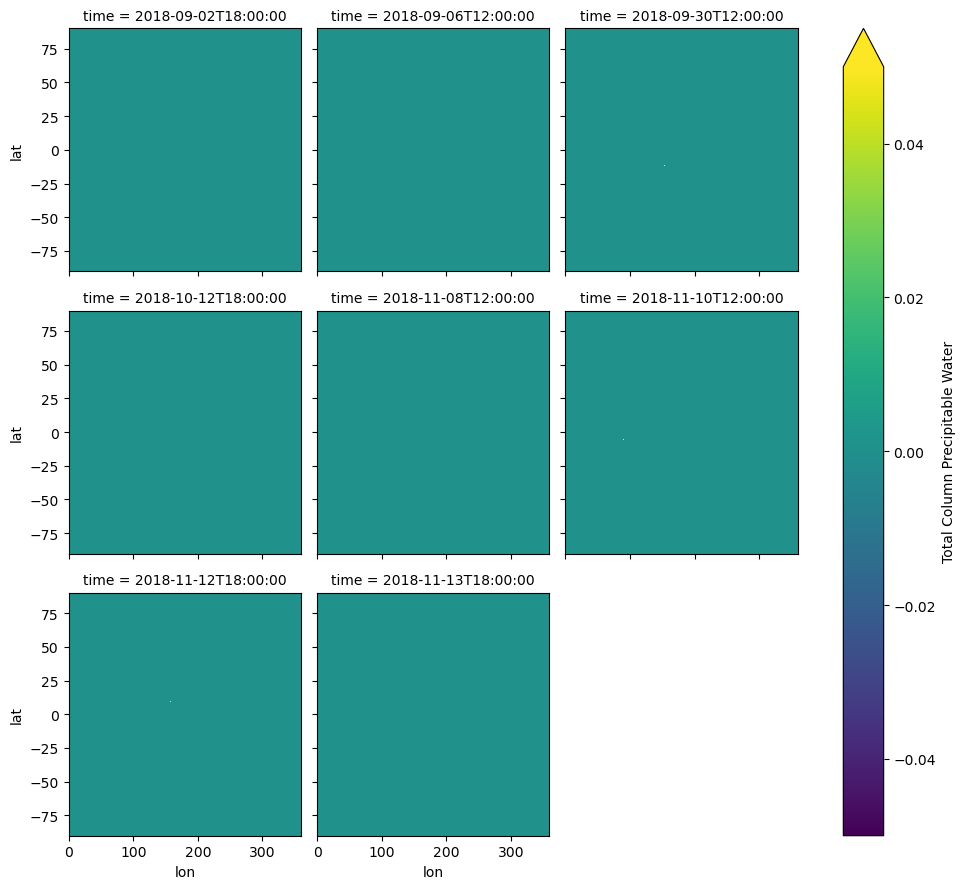

In [38]:
florence_nc = "/root/data_downloads/era5_labeled_regridded/2018-09-01.nc"
dataset = xr.open_dataset(florence_nc)
times = dataset["time"]
dataset["time"]=pd.to_datetime(times, unit='h', origin='1900-01-01 00:00:00.0')

dataset = dataset.reindex(lat=list(reversed(dataset.lat)))
# dataset["TMQ"][1].plot()
dataset["LABELS"].sortby(["lat","lon"]).plot.pcolormesh(
    x="lon",
    y="lat",
    col="time",
    col_wrap=3,
    robust=True,
    cmap="viridis",
    cbar_kwargs={"label": "Total Column Precipitable Water"},
)

dataset.close()
# dataset["WS850"].plot.contour()
# tcwv.isel(time=0).plot.contourf()
# plt.show()
# pv850.isel(time=0).plot.contourf()
# plt.show()
# mtpr.isel(time=0).plot.contourf()
# plt.show()
# ws850.isel(time=0).plot.contourf()
# plt.show()
# # plt.colorbar()
